# Declaration
>- Env:Look the follow cell, you can double click for full view.
>- About language:To study English for read [tensorflow API](https://tensorflow.google.cn/versions/r2.3/api_docs/python/tf).
>- Epic:Upon finishing this Notebook, to express my great gratitude towards all those who have offered me sincere assistance and thought especially K同学啊 and heywhale.

In [1]:
%pip list | grep -E "tensorflow|matplotlib|Pillow"

matplotlib                   3.5.2              
matplotlib-inline            0.1.3              
Pillow                       9.2.0              
tensorflow                   2.9.0              
tensorflow-estimator         2.9.0              
tensorflow-io-gcs-filesystem 0.26.0             
Note: you may need to restart the kernel to use updated packages.


## Import libs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense


## View file structure

In [3]:
# View data directory
%ls ./weather_photos/

cloudy/  rain/  shine/  sunrise/


In [4]:
%ls weather_photos/cloudy|head -n 1

cloudy100.jpg
ls: 写入错误


 The dataset contains four sub-directories, one per class:
 ```
 weather_photos/
		cloudy/
		rain/
		shine/
		sunrise/
				*.jpg
 ```

In [5]:
data_dir = "./weather_photos/"
# Instantiating a pathlib object
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Number of image：",image_count)

Number of image： 1125


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [6]:
class_names = [i.name for i in data_dir.glob('*')]
class_names

['sunrise', 'cloudy', 'shine', 'rain']

## Visualize the first image

Here are the first image:

data_dir.glob(re_path) Return a generator object.

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=315x197 at 0x7F997FDE9850>


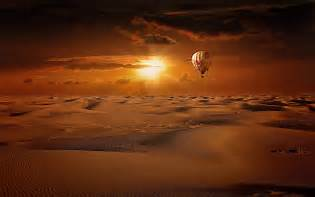

In [7]:
re_path = '%s/*.jpg'%(class_names[0])
for i in data_dir.glob(re_path):
    break
img = PIL.Image.open(i)
print(img)
PIL.Image.open(i)


 ## Image structure
Get the size and mode of the image from the above , **JpegImageFile image mode=RGB size=600x400**

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.preprocessing.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb) tutorial.

# Resource
>- 本文为[🔗365天深度学习训练营](https://mp.weixin.qq.com/s/k-vYaC8l7uxX51WoypLkTw) 中的学习记录博客
>- 参考文章地址： [🔗深度学习100例-卷积神经网络（CNN）天气识别 | 第5天](https://mtyjkh.blog.csdn.net/article/details/117186183)
>- 参考colab地址：[🔗images_classification](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=qFYx7Z2SIjr8)
>- 参考tensorflowAPI:[🔗tf.keras.preprocessing.image_dataset_from_directory](https://tensorflow.google.cn/versions/r2.3/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

## Create a dataset
Define some parameters for the loader:

In [8]:
# set 32 times for wrap
batch_size = 32
img_height = 192 
img_width = 192

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=3,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1125 files belonging to 4 classes.
Using 900 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=3,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1125 files belonging to 4 classes.
Using 225 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [11]:
class_names = train_ds.class_names
print(class_names)

['cloudy', 'rain', 'shine', 'sunrise']


## Visualize the data

Here are the first nine images from the training dataset:

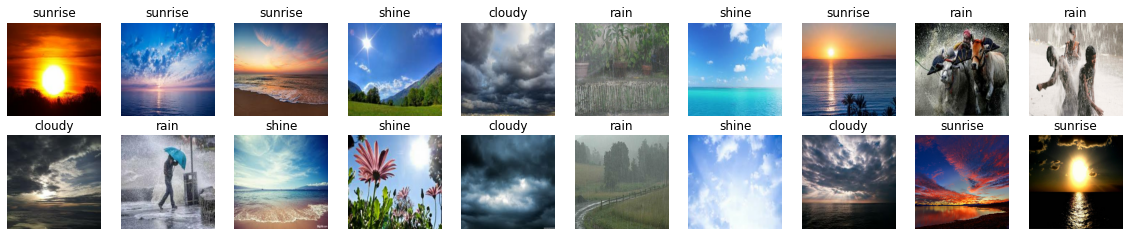

In [12]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(5, 10, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to Model.fit in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 192, 192, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 192, 192, 3)`. This is a batch of 32 images of shape `192x192x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](.https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb) guide.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(256).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [15]:
normalization_layer = layers.Rescaling(1./255)


In [16]:
normalization_layer

# Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU. But I use tensorflow.keras.preprocessing.image.ImageDataGenerator

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

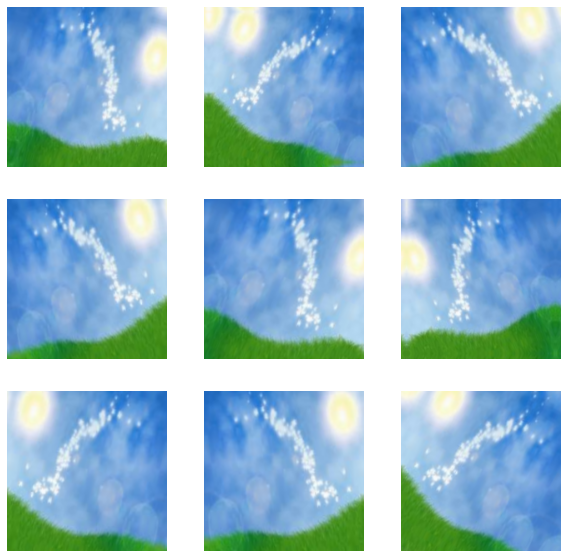

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class VGG16(Model):
    def __init__(self):
        super(VGG16, self).__init__()
        self.data_aug1 = RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3))
        self.data_aug2 = RandomRotation(0.1)
        self.data_aug3 = RandomZoom(0.1) 
        self.c1 = Conv2D(filters=64, kernel_size=(3, 3), padding='same')  # 卷积层1
        self.b1 = BatchNormalization()  
        self.a1 = Activation('relu') 
        self.c2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', )
        self.b2 = BatchNormalization()  
        self.a2 = Activation('relu')  
        self.p1 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d1 = Dropout(0.2) 

        self.c3 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')
        self.b3 = BatchNormalization() 
        self.a3 = Activation('relu')  
        self.c4 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')
        self.b4 = BatchNormalization() 
        self.a4 = Activation('relu')  
        self.p2 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d2 = Dropout(0.2)  

        self.c5 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b5 = BatchNormalization()  
        self.a5 = Activation('relu')  
        self.c6 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b6 = BatchNormalization()  
        self.a6 = Activation('relu')  
        self.c7 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b7 = BatchNormalization()
        self.a7 = Activation('relu')
        self.p3 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d3 = Dropout(0.2)

        self.c8 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b8 = BatchNormalization()  
        self.a8 = Activation('relu')  
        self.c9 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b9 = BatchNormalization()  
        self.a9 = Activation('relu')  
        self.c10 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b10 = BatchNormalization()
        self.a10 = Activation('relu')
        self.p4 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d4 = Dropout(0.2)

        self.c11 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b11 = BatchNormalization()  
        self.a11 = Activation('relu')  
        self.c12 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b12 = BatchNormalization()  
        self.a12 = Activation('relu')  
        self.c13 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b13 = BatchNormalization()
        self.a13 = Activation('relu')
        self.p5 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d5 = Dropout(0.2)

        self.flatten = Flatten()
        self.f1 = Dense(512, activation='relu')
        self.d6 = Dropout(0.2)
        self.f2 = Dense(512, activation='relu')
        self.d7 = Dropout(0.2)
        self.f3 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.data_aug1(x)
        x = self.data_aug2(x)
        x = self.data_aug3(x)
        
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        x = self.c2(x)
        x = self.b2(x)
        x = self.a2(x)
        x = self.p1(x)
        x = self.d1(x)

        x = self.c3(x)
        x = self.b3(x)
        x = self.a3(x)
        x = self.c4(x)
        x = self.b4(x)
        x = self.a4(x)
        x = self.p2(x)
        x = self.d2(x)

        x = self.c5(x)
        x = self.b5(x)
        x = self.a5(x)
        x = self.c6(x)
        x = self.b6(x)
        x = self.a6(x)
        x = self.c7(x)
        x = self.b7(x)
        x = self.a7(x)
        x = self.p3(x)
        x = self.d3(x)

        x = self.c8(x)
        x = self.b8(x)
        x = self.a8(x)
        x = self.c9(x)
        x = self.b9(x)
        x = self.a9(x)
        x = self.c10(x)
        x = self.b10(x)
        x = self.a10(x)
        x = self.p4(x)
        x = self.d4(x)

        x = self.c11(x)
        x = self.b11(x)
        x = self.a11(x)
        x = self.c12(x)
        x = self.b12(x)
        x = self.a12(x)
        x = self.c13(x)
        x = self.b13(x)
        x = self.a13(x)
        x = self.p5(x)
        x = self.d5(x)

        x = self.flatten(x)
        x = self.f1(x)
        x = self.d6(x)
        x = self.f2(x)
        x = self.d7(x)
        y = self.f3(x)
        return y

In [19]:
num_classes = 4


model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), # 卷积层1，卷积核3*3  
    layers.AveragePooling2D((2, 2)),               # 池化层1，2*2采样
    layers.Conv2D(32, (3, 3), activation='relu'),  # 卷积层2，卷积核3*3
    layers.AveragePooling2D((2, 2)),               # 池化层2，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'),  # 卷积层3，卷积核3*3
    layers.Dropout(0.3),  
    
    layers.Flatten(),                       # Flatten层，连接卷积层与全连接层
    layers.Dense(128, activation='relu'),   # 全连接层，特征进一步提取
    layers.Dense(num_classes)               # 输出层，输出预期结果
])

model.summary()  # 打印网络结构


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 192, 192, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 192, 192, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 190, 190, 64)      1792      
                                                                 
 average_pooling2d (AverageP  (None, 95, 95, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 93, 93, 32)        18464     
                                                                 
 average_pooling2d_1 (Averag  (None, 46, 46, 32)       0         
 ePooling2D)                                          

In [26]:
num_classes = 4


model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', input_shape=(img_height, img_width, 3)), 
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='same'),         
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'), 
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='same'),           
    layers.Dropout(0.2),  
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'), 
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='same'),         
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'), 
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='same'),                
    layers.Dropout(0.2),  

    layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same'), 
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='same'),              
    layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same'), 
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='same'),  
    layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same'), 
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='same'),              
    layers.Dropout(0.2),  

    layers.Flatten(),                       
    layers.Dense(256, activation='relu'),  
    layers.Dropout(0.2),  
    layers.Dense(256, activation='relu'),   
    layers.Dropout(0.2),  
    layers.Dense(num_classes)             
])

model.summary()  # 打印网络结构

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 192, 192, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 192, 192, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 192, 192, 64)      1792      
                                                                 
 batch_normalization_7 (Batc  (None, 192, 192, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 192, 192, 64)      0         
                                                                 
 average_pooling2d_9 (Averag  (None, 96, 96, 64)       0         
 ePooling2D)                                          

In [27]:
# 设置优化器
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

In [28]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29/29 [==============================] - ETA: 0s - loss: 0.7664 - accuracy: 0.6500WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f997c0abef0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<Figure size 1152x576 with 2 Axes>